In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
1
0
GeForce RTX 2080 with Max-Q Design


In [3]:
data_dir = '../../Images/BottleStoodUp_atNight/Positive'      #This is for the home laptop
# data_dir = '../../../../BottleStoodUp_atNight/Positive/'        #For the work laptop

In [4]:
# transform_characteristics = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor()])
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset = datasets.ImageFolder(data_dir, transform=transform_characteristics)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)

The dataloader is compoosed of 12 batches, each of them of size 15 making a total of: 180, which is enough for storing the 179 images that we have in the positive dataset

In [5]:
print(len(dataloader))

12


In [6]:
images, labels = next(iter(dataloader))
print("The images are stored in a variable of type: ", type(images))
print("The classes labels are: ", labels)
print(torch.min(images), torch.max(images))

c:\Users\alexj\.conda\envs\tfm_3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


The images are stored in a variable of type:  <class 'torch.Tensor'>
The classes labels are:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0.0007) tensor(1.)


In [7]:
for i, (_data, _) in enumerate(dataloader):
    if(i==9):
        break
    print(i)

0
1
2
3
4
5
6
7
8


# Showing one sample of the training set images

Grabbing only one image of the training set, permuting its shape sizes and converting to numpy to able to display it.

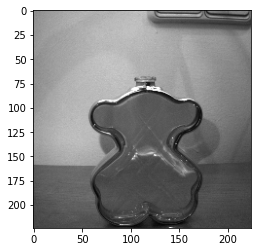

In [8]:
single_img = images[0]
single_img_permuted = single_img.permute(1, 2, 0) 
single_img_numpy = single_img_permuted.detach().numpy()

plt.imshow(single_img_numpy)

# Building the model Autoencoder model

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()        
        # 15, 3, 224, 224.  Batch size, input channels, shape of the image.
        input_channels = 3              # number of channels of the input image
        output_channels = 110           # ~= 224/2. Shape of the input image divided by 2 approximately. 
        kernel_size = 9
        padding_val = 1
        stride_val = 5

        
        output_channels_layer2 = output_channels*2+5

        output_channels_layer3 = output_channels_layer2*2
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride=stride_val, padding=padding_val),         # Dimension rseult: -> 15, 110, 44, 44. Batch size, channel output, output image shape
            nn.ReLU(),
            nn.Conv2d(output_channels, output_channels_layer2, kernel_size, stride=stride_val, padding=padding_val), # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.Conv2d(output_channels_layer2, output_channels_layer3, 8) # Dimension rseult: -> 15, 450, 1, 1
        )

        self.fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        self.encoder_tanh = nn.Tanh()
        

        self.decoder_tanh = nn.Tanh()
        self.decoder_fc = nn.Linear(output_channels_layer3, output_channels_layer3)
        # Initial dimension for this part of the model: 15 , 450, 1, 1
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(output_channels_layer3, output_channels_layer2, 8),  # Dimension rseult: -> 15, 225, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels_layer2, output_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 110, 44, 44
            nn.ReLU(),
            nn.ConvTranspose2d(output_channels, input_channels, kernel_size, stride=stride_val, padding=padding_val, output_padding=2), # Dimension rseult: -> 15, 1, 224, 224
            nn.Sigmoid()
        )

        

    def forward(self, x, flag = False):
        if flag:
            print("The FORWARD function is starting")

            print("The ENCODER part is executing")
            encoded = self.encoder(x)
            print("encoded shape after the entire encoder sequence net is:", encoded.shape)
            encoded = encoded.view(encoded.size(0), -1)
            print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            linearCombined = self.fc(encoded)
            print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            tanhed = self.encoder_tanh(linearCombined)
            print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450

            print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            print("decoded shape is:", decoded.shape)
            print("Finish the FORWARD function")
        else:
            # print("The FORWARD function is starting")

            # print("The ENCODER part is executing")
            encoded = self.encoder(x)
            # print("encoded shape after the entire encoder sequence net is:", encoded.shape)
            encoded = encoded.view(encoded.size(0), -1)
            # print("encoded shape after the encoded.view is: ", encoded.shape)           # Dimension rseult: -> 15, 450
            linearCombined = self.fc(encoded)
            # print("linearCombined shape after the self.fc is: ", linearCombined.shape)  # Dimension rseult: -> 15, 450
            tanhed = self.encoder_tanh(linearCombined)
            # print("tanhed shape after the self.encoder_tanh is: ", tanhed.shape)  # Dimension rseult: -> 15, 450

            # print("The DECODER part is executing")
            dec_tanhed = self.decoder_tanh(tanhed)
            # print("dec_tanhed shape after the self.decoder_tanh is: ", dec_tanhed.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = self.decoder_fc(dec_tanhed)
            # print("dec_linearCombined shape after the self.decoder_fc is: ", dec_linearCombined.shape)  # Dimension rseult: -> 15, 450
            dec_linearCombined = dec_linearCombined.view(-1, dec_linearCombined.size(1), 1, 1)
            # print("dec_linearCombined shape after the dec_linearCombined.view is: ", dec_linearCombined.shape)           # Dimension rseult: -> 15, 450, 1, 1
            decoded = self.decoder(dec_linearCombined)
            # print("decoded shape is:", decoded.shape)
            # print("Finish the FORWARD function")
        return decoded
    
 
# Note: nn.MaxPool2d -> use nn.MaxUnpool2d, or use different kernelsize, stride etc to compensate...
# Input [-1, +1] -> use nn.Tanh

Making sure to use the GPU for the trainig stage

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)

cuda:0


In [11]:
model = Autoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [12]:
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(110, 225, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(225, 450, kernel_size=(8, 8), stride=(1, 1))
  )
  (fc): Linear(in_features=450, out_features=450, bias=True)
  (encoder_tanh): Tanh()
  (decoder_tanh): Tanh()
  (decoder_fc): Linear(in_features=450, out_features=450, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(450, 225, kernel_size=(8, 8), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(225, 110, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(110, 3, kernel_size=(9, 9), stride=(5, 5), padding=(1, 1), output_padding=(2, 2))
    (5): Sigmoid()
  )
)

In [13]:
# torch.cuda.empty_cache()

In [14]:
epochs_toCheck_earlyStopping = 100
min_diff_earlyStopping = 0.0005

num_epochs = 300
outputs = []
prev_losses = [float('inf')] * epochs_toCheck_earlyStopping  # Initialize previous losses with infinity
losses_list = []
for epoch in range(num_epochs):
    for (img, _) in dataloader:     # This iterates over the batches of images.
        img = img.to(device)
        # Forward pass
        recon = model(img)          # The entire batch of images is passed to the model
        loss = criterion(recon, img)

        # Backward and optimize
        optimizer.zero_grad()       # Sets the gradients of all optimized torch.Tensors to zero
        loss.backward()             # The accumulation (or sum) of all the gradients is calculated     
        optimizer.step()            # can be called once the gradients are computed 

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))


    # Calculate the average loss for the current epoch
    avg_loss = loss.item()
    losses_list.append(avg_loss)
    # Append the current loss to the previous losses list
    prev_losses.append(avg_loss)
    prev_losses = prev_losses[1:]  # Keep only the last 5 losses

    # Check if the last 5 losses are the same (within a tolerance)
    stop_training = all(abs(loss - prev_loss) < min_diff_earlyStopping for prev_loss in prev_losses)

    # Break the training loop if the stopping condition is met
    if stop_training:
        print('Early stopping triggered. Training stopped.')
        break

# open file
with open('RecErrorCleanV3_testing.txt', 'w+') as g:
    # write elements of list
    for items in losses_list:
        g.write('%s\n' %items)
    print("losses_list written successfully")
# close the file
g.close() 

Epoch:1, Loss:0.0198
Epoch:2, Loss:0.0091
Epoch:3, Loss:0.0083
Epoch:4, Loss:0.0069
Epoch:5, Loss:0.0066
Epoch:6, Loss:0.0067
Epoch:7, Loss:0.0066
Epoch:8, Loss:0.0065
Epoch:9, Loss:0.0079
Epoch:10, Loss:0.0064
Epoch:11, Loss:0.0073
Epoch:12, Loss:0.0054
Epoch:13, Loss:0.0052
Epoch:14, Loss:0.0061
Epoch:15, Loss:0.0056
Epoch:16, Loss:0.0057
Epoch:17, Loss:0.0068
Epoch:18, Loss:0.0048
Epoch:19, Loss:0.0051
Epoch:20, Loss:0.0075
Epoch:21, Loss:0.0053
Epoch:22, Loss:0.0063
Epoch:23, Loss:0.0066
Epoch:24, Loss:0.0047
Epoch:25, Loss:0.0047
Epoch:26, Loss:0.0040
Epoch:27, Loss:0.0046
Epoch:28, Loss:0.0045
Epoch:29, Loss:0.0050
Epoch:30, Loss:0.0042
Epoch:31, Loss:0.0042
Epoch:32, Loss:0.0063
Epoch:33, Loss:0.0044
Epoch:34, Loss:0.0048
Epoch:35, Loss:0.0046
Epoch:36, Loss:0.0046
Epoch:37, Loss:0.0046
Epoch:38, Loss:0.0038
Epoch:39, Loss:0.0056
Epoch:40, Loss:0.0042
Epoch:41, Loss:0.0034
Epoch:42, Loss:0.0042
Epoch:43, Loss:0.0055
Epoch:44, Loss:0.0048
Epoch:45, Loss:0.0058
Epoch:46, Loss:0.00

Saving and loading a model

In [15]:
filepath = "models/PytorchTest"


In [16]:
torch.save(model.state_dict(), filepath)

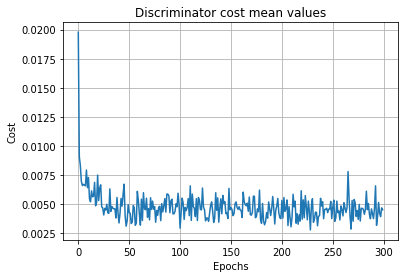

In [17]:
# Load data from the text file
with open("RecErrorCleanV3_testing.txt", "r") as file:
    data = [float(line.strip()) for line in file]

# Plot the data
plt.plot(data)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Discriminator cost mean values")
plt.grid(True)
plt.show()

In [ ]:
# For loading the model 
model.load_state_dict(torch.load(filepath))                                         # For home laptop
# model.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))     # For work laptop
model.eval()

Once the model has been trained we will show the results:

The below function is used for formatting the image to make it able to be showed.

In [18]:
#Utility functions to un-normalize and display an image
def imshow(img):
    # img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

## Analyzing each layer of the Autoencoder model

In [19]:
i = 0
j = 0
for (x, _) in dataloader:                                       # Iterate over the batches of the training set
    if j == 0:
        x = x.to(device)                                        # Place the batch of images to the GPU or CPU depending on the resources
        batch_imgs = x
        code = model(x,True)    
        j = j+1  

print("this is the shape of imgs_croped : ", batch_imgs.shape)
print("this is the shape of code : ", code.shape)

The FORWARD function is starting
The ENCODER part is executing
encoded shape after the entire encoder sequence net is: torch.Size([15, 450, 1, 1])
encoded shape after the encoded.view is:  torch.Size([15, 450])
linearCombined shape after the self.fc is:  torch.Size([15, 450])
tanhed shape after the self.encoder_tanh is:  torch.Size([15, 450])
The DECODER part is executing
dec_tanhed shape after the self.decoder_tanh is:  torch.Size([15, 450])
dec_linearCombined shape after the self.decoder_fc is:  torch.Size([15, 450])
dec_linearCombined shape after the dec_linearCombined.view is:  torch.Size([15, 450, 1, 1])
decoded shape is: torch.Size([15, 3, 224, 224])
Finish the FORWARD function
this is the shape of imgs_croped :  torch.Size([15, 3, 224, 224])
this is the shape of code :  torch.Size([15, 3, 224, 224])


Original Images


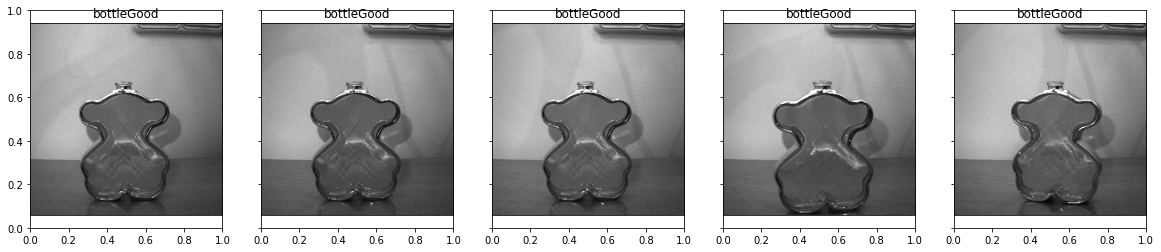

Reconstructed Images


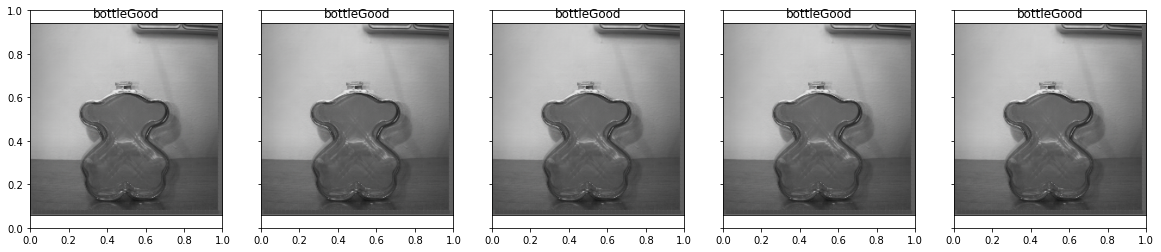

In [20]:
#Batch of test images
dataiter = iter(dataloader)
images, labels = next(dataiter)
images, labels = images.cuda(), labels.cuda()         # add this line for displaying the image. For home laptop
# images, labels = images, labels                         # add this line for displaying the image. For work laptop
#Sample outputs
output = model(images)

images = images.cpu().numpy()

# output = output.view(32, 3, 224, 224)
output = output.view(15, 3, 224, 224)       # Because the batch size was changed to 15
output = output.cpu().detach().numpy()

#Define the image classes
classes = ['bottleGood']

#Original Images
print("Original Images")
# plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(classes[labels[idx]])
plt.show() 

# Quantifying the reconstruction error

Performing the computation of the reconstruction error of all the images in the training dataset. Additionally, consider the mean reconstruction error, rather than the direct sum of these.

In [21]:
X = dataset[0]
image_in_tensor = X[0]
result_lst = []
n_features = len(image_in_tensor[0])  
for i in range(len(dataset)):
    X = dataset[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 3.3480151948474703), (1, 1.5221287863595145), (2, 1.9368055434454055), (3, 0.5295061383928571), (4, 0.33507549195062547), (5, 0.532591774350121), (6, 0.4534269514537993), (7, 0.4788623991466704), (8, 0.4065343765985398), (9, 0.3970804668608166), (10, 0.35357974824451266), (11, 0.318529901050386), (12, 1.547808329264323), (13, 1.4224684579031808), (14, 0.9178916386195591), (15, 0.6493467149280366), (16, 0.36138143993559335), (17, 0.7587490990048363), (18, 0.5406256630307152), (19, 2.093723478771391), (20, 2.713463374546596), (21, 2.650364648728144), (22, 1.7431842258998327), (23, 1.1666396004813058), (24, 0.3807604880560012), (25, 0.6842778977893648), (26, 1.5835834684826078), (27, 1.5555812290736608), (28, 2.08236331031436), (29, 1.9038552783784413), (30, 0.5998270852225167), (31, 0.3908858072190058), (32, 1.5270438421340216), (33, 1.5933841523670016), (34, 1.3646966843377977), (35, 1.0739264715285528), (36, 1.4327813103085472), (37, 1.9678786141531808), (38, 2.2848350888206843), 

In [22]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(0, 3.3480151948474703), (20, 2.713463374546596), (21, 2.650364648728144), (39, 2.632411411830357), (155, 2.302769797188895), (38, 2.2848350888206843), (19, 2.093723478771391), (28, 2.08236331031436), (120, 2.0313626243954612), (37, 1.9678786141531808), (2, 1.9368055434454055), (29, 1.9038552783784413), (146, 1.8685201009114583), (168, 1.804546174548921), (176, 1.7821468171619235), (22, 1.7431842258998327), (177, 1.7360778081984747), (137, 1.6763222104027158), (175, 1.6580149332682292), (178, 1.6034171694800967), (33, 1.5933841523670016), (165, 1.584878649030413), (26, 1.5835834684826078), (27, 1.5555812290736608), (102, 1.5507332938058036), (12, 1.547808329264323), (32, 1.5270438421340216), (1, 1.5221287863595145), (163, 1.4984317961193265), (36, 1.4327813103085472), (164, 1.428231920514788), (169, 1.425152369907924), (167, 1.4230247679210843), (13, 1.4224684579031808), (161, 1.4200367700485956), (144, 1.4101627894810267), (142, 1.4056688036237444), (145, 1.4046544574555897), (143, 1

Gaphically the distribution of the reconstruction error values is shown below:

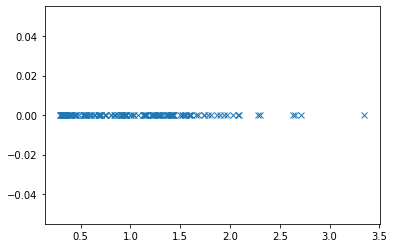

In [23]:
errors_list = []
for i in range(len(result_lst)):
    errors_list.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.show()

In [24]:
average_recon_error = np.mean(np.array(errors_list))  
stdev_recon_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.9625820701317003
The standard deviation of the errors list is:  0.5780436661267978
The min value of the errors list is:  0.2921369189307803
The max value of the errors list is:  3.3480151948474703


## Checking the MSE reconstruction error of the anomaly images

We first load the anomaly images dataset

In [25]:
data_anomalies = '../../Images/BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
# data_anomalies = '../../../../BottleStoodUp_atNight/Anomalies2.0'      #This is for the home laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])
dataset_anomalies = datasets.ImageFolder(data_anomalies, transform=transform_characteristics)
dataloader_anomalies = torch.utils.data.DataLoader(dataset_anomalies, batch_size=32, shuffle=True)

In [26]:
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_anomalies[0]
image_in_tensor = X[0]
image_in_tensor = image_in_tensor.cuda()            # If using the GPU
# image_in_tensor = image_in_tensor            # If NO GPU
n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_anomalies)):
    X = dataset_anomalies[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()            # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append( (i,err) )     # idx of data item, err
print(result_lst)

[(0, 0.41237631298246835), (1, 1.216184343610491), (2, 1.4424450283958798), (3, 3.3547621227446056), (4, 0.7778293064662388), (5, 0.714595840090797)]


In [27]:
result_lst.sort(key=lambda x: x[1], \
reverse=True)  # high error to low
print(result_lst)

[(3, 3.3547621227446056), (2, 1.4424450283958798), (1, 1.216184343610491), (4, 0.7778293064662388), (5, 0.714595840090797), (0, 0.41237631298246835)]


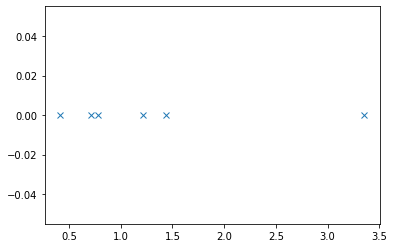

In [28]:
errors_list_anomalies = []
for i in range(len(result_lst)):
    errors_list_anomalies.append(result_lst[i][1])  

val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'x')
plt.show()

In [29]:
average_recon_error = np.mean(np.array(errors_list_anomalies))  
stdev_recon_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", average_recon_error)
print("The standard deviation of the errors list is: ", stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE ANOMALY IMAGES

The average of the errors list is:  1.3196988257150801
The standard deviation of the errors list is:  0.9704183670294333
The min value of the errors list is:  0.41237631298246835
The max value of the errors list is:  3.3547621227446056


## Comparing the reconstruction error of anomaly and normal images

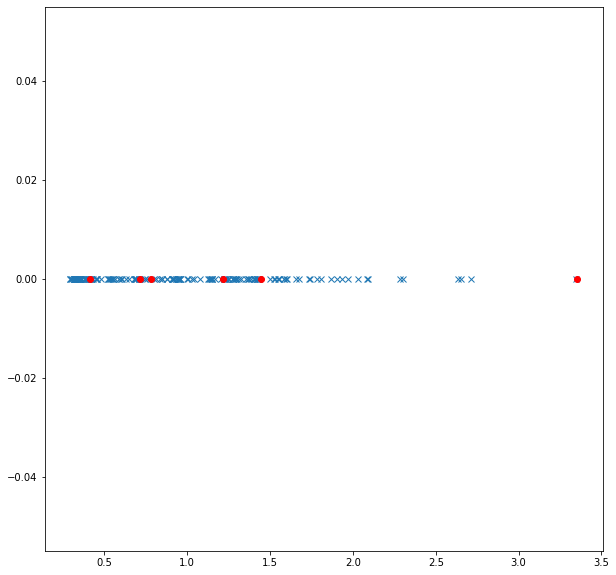

In [30]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(errors_list, np.zeros_like(errors_list) + val, 'x')
plt.plot(errors_list_anomalies, np.zeros_like(errors_list_anomalies) + val, 'ro')
plt.show()

Above see that the reconstruction error between normal and anomaly images are NOT clearly divided in the plot. This could be a problem for the overall detection.

# Coding a function to check if an image contains anomalies

We know that for the non-anomaly images, the mean and std devation is:

In [31]:
na_avg_rcn_error = np.mean(np.array(errors_list))  
na_stdev_rcn_error = np.std(np.array(errors_list)) 
min_prob = np.min(errors_list)
max_prob = np.max(errors_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_avg_rcn_error)
print("The standard deviation of the errors list is: ", na_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES

The average of the errors list is:  0.9625820701317003
The standard deviation of the errors list is:  0.5780436661267978
The min value of the errors list is:  0.2921369189307803
The max value of the errors list is:  3.3480151948474703


And for the anomaly image, the std deviation and mean values are:

In [32]:
a_avg_rcn_error = np.mean(np.array(errors_list_anomalies))  
a_stdev_rcn_error = np.std(np.array(errors_list_anomalies)) 
min_prob = np.min(errors_list_anomalies)
max_prob = np.max(errors_list_anomalies)
print("THIS IS FOR THE TRAINING ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_avg_rcn_error)
print("The standard deviation of the errors list is: ", a_stdev_rcn_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

THIS IS FOR THE TRAINING ANOMALY IMAGES

The average of the errors list is:  1.3196988257150801
The standard deviation of the errors list is:  0.9704183670294333
The min value of the errors list is:  0.41237631298246835
The max value of the errors list is:  3.3547621227446056


According to this, we will work with the following:

- The error value is 0.960174. This is exactly the average of the non-anomaly distribution, then it should have a 0% probability of being detected as an anomaly image.
- The error value is 0.960174 +/- 0.616043. Then the probability of being detected as an anomaly bottle is 50%. And, as typically, we decide that a value higher than 50% is considered as an anomaly image, then every value higher or lower than this quantity will be considered as an anomaly image.

In [33]:
def ranges_mapper(value, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valueScaled * rightSpan)

In [34]:
def map_error2prob(value):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    aux_score = value - mean
    prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
    if prob_score<0:
        prob_score = 0
    if prob_score>100:
        prob_score = 100
    return prob_score

Testing a reconstruction error. Verifying that given some reconstruction error, the probability value is the one we expect. 

In [35]:
print(map_error2prob(na_avg_rcn_error + na_stdev_rcn_error))

50.0


In [36]:
def map_error2prob_list(input_list):
    # Calculate the mean and standard deviation
    mean = na_avg_rcn_error
    std_dev = na_stdev_rcn_error
    prob_score_list = []
    for i in range (len(input_list)):
        aux_score = input_list[i] - mean
        prob_score = ranges_mapper(abs(aux_score), 0, std_dev, 0, 50)
        if prob_score<0:
            prob_score = 0
        if prob_score>100:
            prob_score = 100
        prob_score_list.append(prob_score)
    return prob_score_list

Checking the probability of being detected as anomaly images of the set of non-anomaly images. Ideally, all these images should output a probability of around 0%, because these are not anomaly images.

Moreover, we decide whether an image is anomaly or not, based on its reconstruction error.

In [37]:
print("Considering the non-anomaly dataset. The number of images to be cheked is: ", len(errors_list))
preds_probs = np.array(map_error2prob_list(errors_list))
preds_probs = preds_probs/100
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

Considering the non-anomaly dataset. The number of images to be cheked is:  179
The prediction probabilities list for the non-anomaly images is: 
[1.         1.         1.         1.         1.         1.
 0.97842211 0.96859572 0.92448081 0.869568   0.84269021 0.81418867
 0.78362422 0.72828763 0.70891249 0.67521037 0.66906341 0.61737563
 0.60154008 0.55431375 0.54563532 0.53827817 0.53715786 0.5129363
 0.5087429  0.50621285 0.48825184 0.48400039 0.46350281 0.40671602
 0.40278086 0.40011709 0.39827674 0.39779554 0.39569217 0.3871513
 0.38326407 0.38238667 0.37955745 0.364515   0.35545114 0.34870514
 0.34782374 0.33716583 0.31473221 0.3011545  0.28971449 0.28484662
 0.28246325 0.28172947 0.2730303  0.2717362  0.26983324 0.26975476
 0.25174214 0.24625818 0.23643179 0.2323065  0.2323065  0.22911754
 0.22642383 0.22260722 0.20707077 0.17650702 0.16385062 0.16284846
 0.16171809 0.1563728  0.15182547 0.14791411 0.14166786 0.09631141
 0.06742523 0.05735788 0.03800497 0.03002796 0.00671055 0.00

Let's now check the reconstruction error of the anomaly images.

In [38]:
print("Considering the anomaly dataset. The number of images to be cheked is: ", len(errors_list_anomalies))
preds_probs = np.array(map_error2prob_list(errors_list_anomalies))
preds_probs = preds_probs/100
print("The prediction probabilities list for the anomaly images is: ")
print(preds_probs)

Considering the anomaly dataset. The number of images to be cheked is:  6
The prediction probabilities list for the anomaly images is: 
[1.         0.41507501 0.21936256 0.15980866 0.21450476 0.47592058]


See that for the classification of the anomaly images we have:
- One samples that was correctly identified as anomaly images.
- Five samples that were classified as non-anomaly. These are false negatives.


# Evaluating the performance of the model

So far, it has been used two dataset for doing the above tests: The full non-anomalies dataset and a full anomalies dataset. We will create a third dataset with a mix of these two types of images.

In [39]:
test_dir = '../../Images/BottleStoodUp_atNight/Evaluation'      #This is for the home laptop
# test_dir = '../../../../BottleStoodUp_atNight/Evaluation'      #This is for the work laptop
transform_characteristics = transforms.Compose([transforms.ToTensor(),
                                                transforms.Resize(255),
                                                transforms.CenterCrop(224)])

dataset_test = datasets.ImageFolder(test_dir, transform=transform_characteristics)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)
classes = ('non-anomaly','anomaly')

In [40]:
def computePred(err_value):
    pred = 0
    prob_anomaly = map_error2prob(err_value)/100
    if prob_anomaly > 0.5:
        pred = 1
    return pred


In [41]:
y_true = []
result_lst = []

# Grabbing only the first image of the anomalies dataset
X = dataset_test[0]
image_in_tensor = X[0]

n_features = len(image_in_tensor[0])  # Get the size of one image of the anomaly images dataset. This is supposed to be 224
for i in range(len(dataset_test)):
    X = dataset_test[i]
    image_in_tensor = X[0]
    image_in_tensor = image_in_tensor[None, :].cuda()   # If using the GPU
    # image_in_tensor = image_in_tensor[None, :]   # If NO GPU
    ground_truth = X[1]

    with torch.no_grad():
        Y = model(image_in_tensor)  # should be same as X
    err = torch.sum((image_in_tensor-Y)*(image_in_tensor-Y)).item()  # SSE all features
    err = err/(n_features*3)        # dividing by n_features*3 becuase we have three channels
    result_lst.append(err)     # idx of data item, err
    y_true.append(ground_truth) # Save Truth
print(result_lst)
print(y_true)

[1.6840064639136905, 1.5382648649669828, 1.4001221429734003, 1.4068145751953125, 1.3695643288748605, 1.333999997093564, 1.4434275854201544, 1.5048789978027344, 1.8229771568661643, 1.6121644519624256, 1.7818407331194197, 1.6976877848307292, 1.8116542271205358, 1.6096968877883184, 1.4592546735491072, 1.751595451718285, 1.3043479919433594, 1.1982472737630208, 1.4339858463832311, 1.9835582914806547, 1.9666199457077753, 2.0560404459635415, 2.175269353957403, 2.152491251627604, 1.8347084408714658, 1.8995372227260046, 1.8754710242861794, 1.815254393078032, 1.798860095796131, 1.9479070390973772]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [42]:
print(type(result_lst))

<class 'list'>


In [43]:
from sklearn import metrics
print('AUC = ', metrics.roc_auc_score(y_true, result_lst))

AUC =  0.76


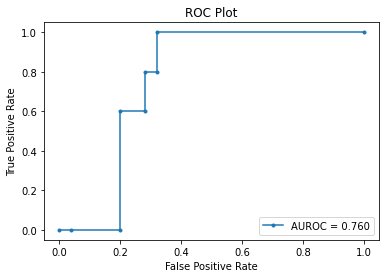

In [44]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, result_lst)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, result_lst))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [45]:
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

The fpr is:  [0.   0.04 0.2  0.2  0.28 0.28 0.32 0.32 1.  ]
The tpr is:  [0.  0.  0.  0.6 0.6 0.8 0.8 1.  1. ]
The thresholds are:  [3.17526935 2.17526935 1.96661995 1.87547102 1.82297716 1.81525439
 1.81165423 1.7988601  1.19824727]


Now, let's try to compute the AUC score with the probability score rather than directly the reconstruction error, which is stored in the "result_lst" variable

In [46]:
print(result_lst)

[1.6840064639136905, 1.5382648649669828, 1.4001221429734003, 1.4068145751953125, 1.3695643288748605, 1.333999997093564, 1.4434275854201544, 1.5048789978027344, 1.8229771568661643, 1.6121644519624256, 1.7818407331194197, 1.6976877848307292, 1.8116542271205358, 1.6096968877883184, 1.4592546735491072, 1.751595451718285, 1.3043479919433594, 1.1982472737630208, 1.4339858463832311, 1.9835582914806547, 1.9666199457077753, 2.0560404459635415, 2.175269353957403, 2.152491251627604, 1.8347084408714658, 1.8995372227260046, 1.8754710242861794, 1.815254393078032, 1.798860095796131, 1.9479070390973772]


In [47]:
na_avg_rcn_error + na_stdev_rcn_error

1.540625736258498

In [48]:
preds_probs = np.array(map_error2prob_list(result_lst))
print("The prediction probabilities list for the non-anomaly images is: ")
print(preds_probs)

The prediction probabilities list for the non-anomaly images is: 
[ 62.40224018  49.79578781  37.84662807  38.42551446  35.20341824
  32.12715135  41.59249063  46.90795518  74.42301829  56.18800273
  70.86477294  63.58565605  73.44360009  55.97456175  42.96151247
  68.24859676  29.56229277  20.38472329  40.77579289  88.31307055
  86.84792641  94.58267947 100.         100.          75.43775859
  81.04536106  78.96366725  73.75500961  72.33692493  85.22928515]


With the above result the AUC score is expected to be lower than the previous one.

AUC =  0.76


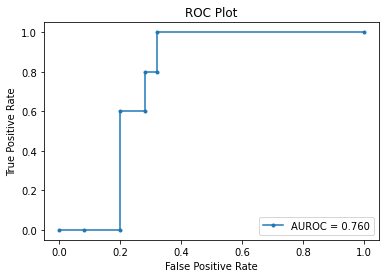

In [49]:
print('AUC = ', metrics.roc_auc_score(y_true, preds_probs))
fpr, tpr, thresholds = metrics.roc_curve(y_true, preds_probs)
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % metrics.roc_auc_score(y_true, preds_probs))
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

The result is surprisingly good. This is the same as the AUC score of the directly reconstruction errors. 

Let's see the prediction labels of this second approach, the one that considers the theshold value, the "preds_probs" variable.


In [50]:
def computePredList(probs_list):
    pred = 0
    pred_list =[]
    for i in range (len(probs_list)):
        if probs_list[i] > 50:              # Working with a threshold of 50%
            pred = 1
        else:
            pred = 0
        pred_list.append(pred)
    return pred_list

In [51]:
y_pred = computePredList(preds_probs)
print("The groudn truth is: ", y_true)
print("The predicted label is: ", y_pred)

The groudn truth is:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
The predicted label is:  [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Applying evaluation metrics to these results

## Computing the confusion matrix

In [52]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [53]:
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

[[11 14]
 [ 0  5]]


Text(0.5, 15.0, 'Predicted label')

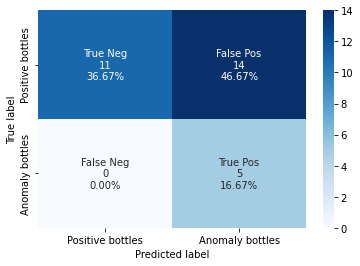

In [54]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]        #To print the group names as well 

labels = np.asarray(labels).reshape(2,2)
categories = ['Positive bottles', 'Anomaly bottles']
sn.heatmap(conf_matrix, annot=labels, fmt='', xticklabels=categories,yticklabels=categories, cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [55]:
_tp = conf_matrix[1, 1]
_fn = conf_matrix[1, 0]
_fp = conf_matrix[0, 1]
_tn = conf_matrix[0, 0]
_tpr = _tp/(_tp+_fn)
_fpr = _fp / (_tn + _fp)
print("The FPR values are: ", _fpr)
print("The TPR values are: ", _tpr)

The FPR values are:  0.56
The TPR values are:  1.0


## Precision metric

Precision = True positives / (True positives + False positives).

Answers the question: Which proportion of positive predictions is actually right?

In [56]:
precision = _tp/(_tp+_fp)
print("The precision is: ", precision)


The precision is:  0.2631578947368421


## Recall metric

Recall = TruePositives / (TruePositives + FalseNegatives)

This metric is also called "sensitiviy" and TPR "True Positive Rate". It responds how good is the model at catching YESes?

In [57]:
recall = _tp/(_tp+_fn)
print("The recall is: ", recall)

The recall is:  1.0


## Specificity

Specificity = True negatives / (True negatives + false positives)

The specificity metric is the opposite as sensitivity, it tells us how good is the model at catching NOes. It measures the proportion of actual negatives that are correctly identified as such.

In [58]:
spec = _tn/(_tn+_fp)
print("The specificity is: ", spec)

The specificity is:  0.44


## Accuracy

Accuracy = (True negatives + True positives) / (True positives + True negatives + False positives + False negatives)

In [59]:
acc = (_tn+_tp)/(_tn+_tp +_fp + _fn)
print("The accuracy is: ", acc)

The accuracy is:  0.5333333333333333


## The ROC curve

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score


Rather than the prediction of each sample (0 or 1 values) we need the probability of the samples to be predicted as an anomaly image. Hence, we compute this probability

In [61]:
auc_score = roc_auc_score(y_true, preds_probs)
print('AUROC = %.3f' % (auc_score))
fpr, tpr, thresholds = roc_curve(y_true, preds_probs)
print("The fpr is: ", fpr)
print("The tpr is: ", tpr)
print("The thresholds are: ", thresholds)

AUROC = 0.760
The fpr is:  [0.   0.08 0.2  0.2  0.28 0.28 0.32 0.32 1.  ]
The tpr is:  [0.  0.  0.  0.6 0.6 0.8 0.8 1.  1. ]
The thresholds are:  [101.         100.          86.84792641  78.96366725  74.42301829
  73.75500961  73.44360009  72.33692493  20.38472329]


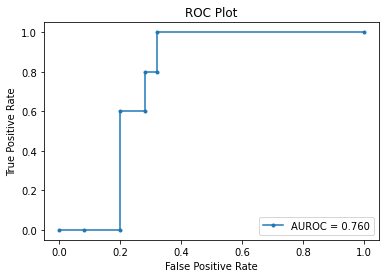

In [62]:
plt.plot(fpr, tpr, marker='.', label='AUROC = %0.3f' % auc_score)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()